In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

Using TensorFlow backend.


In [2]:
genre_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }
reverse_dict = {v: k for k, v in genre_dict.items()}

In [3]:
npzfile = np.load('../saved_variables/train.npz')
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load('../saved_variables/validation.npz')
X_val = npzfile['arr_0']
y_val = npzfile['arr_1']
print(X_val.shape, y_val.shape)

(800, 640, 128) (800, 8)


In [5]:
npzfile = np.load('../saved_variables/test.npz')
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

(800, 640, 128) (800,)


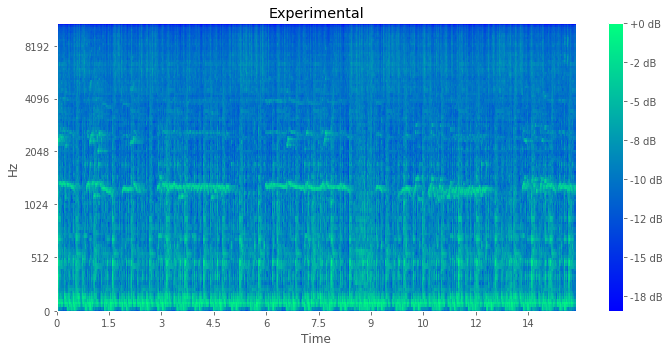

In [6]:
spectogram = X_train[5]
genre = np.argmax(y_train[5])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time', cmap='winter')
plt.colorbar(format='%+2.0f dB')
plt.title(reverse_dict[genre])
plt.tight_layout()

In [7]:
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]
n_layers = 3
filter_length = 5
conv_filter_count = 56
batch_size = 32
lstm_count = 96
epoch_count = 70
n_hidden = 64
L2_regularization = 0.001
input_shape = (None, n_features)
model_input = Input(input_shape, name='input')
print('Building model...')
layer = model_input

for i in range(n_layers):
    layer = Conv1D(
            filters=conv_filter_count,
            kernel_size=filter_length,
            kernel_regularizer=regularizers.l2(L2_regularization),
            name='convolution_' + str(i + 1)
        )(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling1D(2)(layer)
    layer = Dropout(0.4)(layer)

layer = LSTM(lstm_count, return_sequences=False)(layer)
layer = Dropout(0.4)(layer)

layer = Dense(n_hidden, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
layer = Dropout(0.4)(layer)

layer = Dense(num_classes)(layer)
layer = Activation('softmax', name='output_realtime')(layer)
model_output = layer
crnn_model = Model(model_input, model_output)

crnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(crnn_model.summary())
checkpoint_callback = ModelCheckpoint('../saved_variables/crnn_weights.best.hdf5', monitor='val_accuracy', 
                                      verbose=1, save_best_only=True, mode='max')

reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, 
                                      min_delta=0.01, verbose=1)
print('Training...')
# crnn_history = crnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_count,
#                     validation_data=(X_val, y_val), verbose=1, 
#                     callbacks=[checkpoint_callback, reducelr_callback])

Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_1 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None,

In [18]:
crnn_model = load_model('../saved_variables/crnn_weights.best.hdf5')

In [19]:
y_pred = crnn_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, labels=list(genre_dict.values()), target_names=genre_dict.keys()))

               precision    recall  f1-score   support

   Electronic       0.76      0.32      0.45       100
 Experimental       0.29      0.36      0.32       100
         Folk       0.15      0.20      0.17       100
      Hip-Hop       0.62      0.85      0.71       100
 Instrumental       0.34      0.33      0.33       100
International       0.44      0.51      0.47       100
          Pop       0.29      0.28      0.29       100
         Rock       0.71      0.36      0.48       100

     accuracy                           0.40       800
    macro avg       0.45      0.40      0.40       800
 weighted avg       0.45      0.40      0.40       800



In [20]:
print(accuracy_score(y_test, y_pred))

0.40125


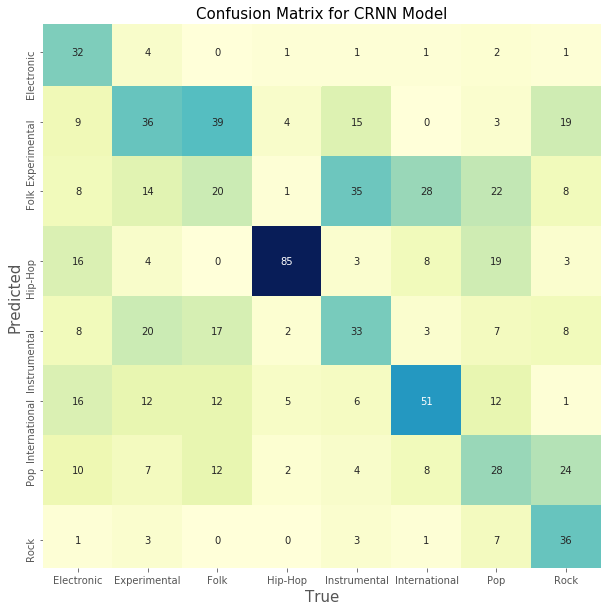

In [31]:
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=genre_dict.keys(),
            yticklabels=genre_dict.keys(), ax=ax)
plt.xlabel('True', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix for CRNN Model', size=15)
ax.set_ylim(8-0.1, 0.1)
plt.savefig('../images/crnn_conf_mat.png')